## Aplicación y reentrenamiento de la arquitectura DERT

Dert

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False)


1.6.0 True


In [71]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [72]:
%cd ./drive/MyDrive/Colab\ Notebooks
%cd ./DERT-finetune/
!ls

[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks/DERT-finetune
[Errno 2] No such file or directory: './DERT-finetune/'
/content/drive/MyDrive/Colab Notebooks/DERT-finetune
convert.py   dert.ipynb			 outputs	  README.md
custom_coco  detr-r50_no-class-head.pth  outputs_ballons  train_custom_coco
data	     getArea.py			 __pycache__


In [14]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [15]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [19]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [16]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

model.eval()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [17]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

In [ ]:
for threshold in [0.9, 0.7, 0.0]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')
           

In [7]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 1

In [ ]:
import convert as via2coco

data_path = './data/'

for keyword in ['train', 'val']:

  input_dir = data_path + 'balloon/' + keyword + '/'
  input_json = input_dir + 'via_region_data.json'
  categories = ['balloon']
  super_categories = ['N/A']
  output_json = input_dir + 'custom_' + keyword + '.json'

  print('Converting {} from VIA format to COCO format'.format(input_json))

  coco_dict = via2coco.convert(
      imgdir=input_dir,
      annpath=input_json,
      categories=categories,
      super_categories=super_categories,
      output_file_name=output_json,
      first_class_index=first_class_index,
  )

In [73]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
# !ls
# !mkdir -p ./train_custom_coco/annotations/
# !mv ./custom_coco/train/_annotations.coco.json ./train_custom_coco/annotations/custom_train.json
# !mv ./custom_coco/valid/_annotations.coco.json ./train_custom_coco/annotations/custom_val.json

# !mkdir -p ./train_custom_coco/train2017/

# !mv ./custom_coco/train/*.jpg ./train_custom_coco/train2017/

# !mkdir -p ./train_custom_coco/val2017/

!mv ./custom_coco/valid/*.jpg ./train_custom_coco/val2017/


mv: cannot stat './custom_coco/valid/*.jpg': No such file or directory


In [ ]:
dataDir='./train_custom_coco/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['example', 'fire hydrant', 'parking meter', 'stop sign']
Super-categories: {'example', 'none'}


In [ ]:
catIds = coco.getCatIds(catNms=['parking meter','stop sign', 'parking meter'])
imgIds = coco.getImgIds(catIds=catIds )

Image n°38
Image name: ./train_custom_coco//train2017/000000054448_jpg.rf.51289088cf109bf40a43aa7bf364be7f.jpg


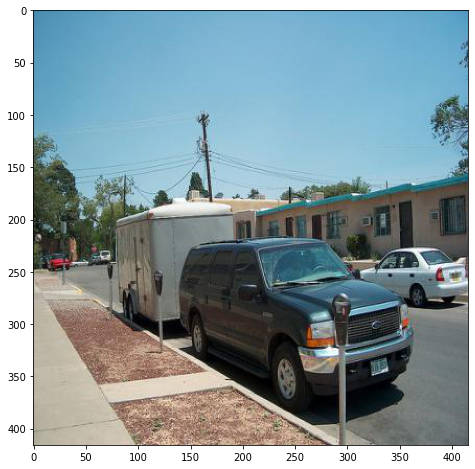

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

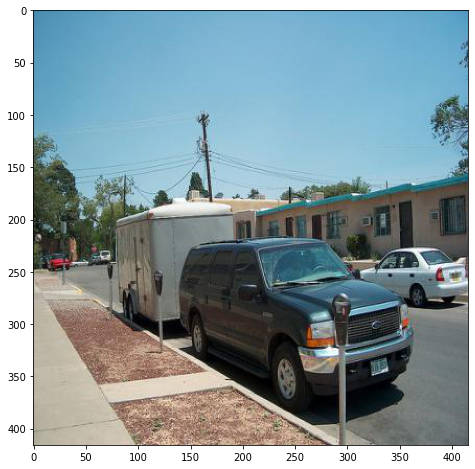

In [ ]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

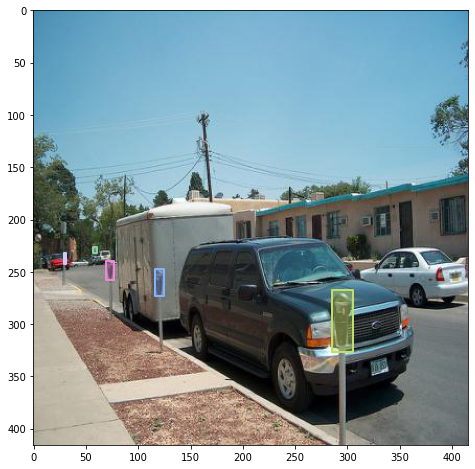

In [ ]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

In [8]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 3

  finetuned_classes = [
      'fire hydrant',
      'parking meter',
      'stop sign'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 4

  finetuned_classes = [
      'example', 'fire hydrant','parking meter', 'stop sign'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 4
Fine-tuned classes: ['example', 'fire hydrant', 'parking meter', 'stop sign']


In [ ]:
!python ./data/detr_finetune/main.py \
  --dataset_file "custom" \
  --coco_path "./train_custom_coco/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 30

Not using distributed mode
git:
  sha: d9fcd241f8d44464f697999619bb9191f9ffa515, status: clean, branch: main

Namespace(aux_loss=True, backbone='resnet50', batch_size=8, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='./train_custom_coco/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=30, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=4, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41280009
loading annotations into memory...
Done (t=0.04s)
creating index...
index 

python ./data/detr_finetune/main.py --dataset_file "custom" --coco_path ./data custom/ --output_dir "outputs" --resume ./detr-r50_no-class-head.pth --num_classes 2 --epochs 10

In [2]:
from data.detr_finetune.util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

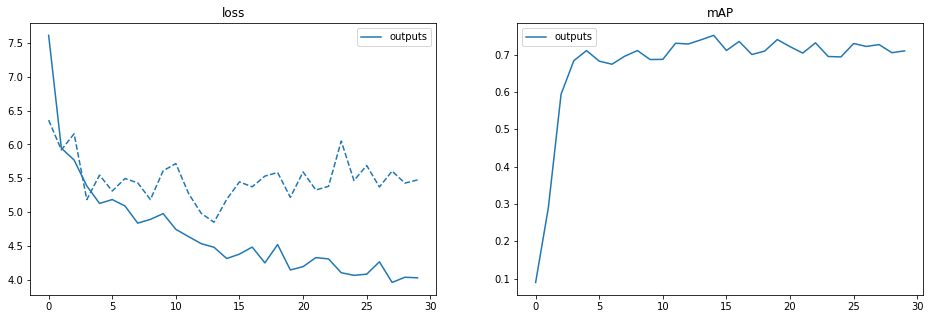

In [3]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

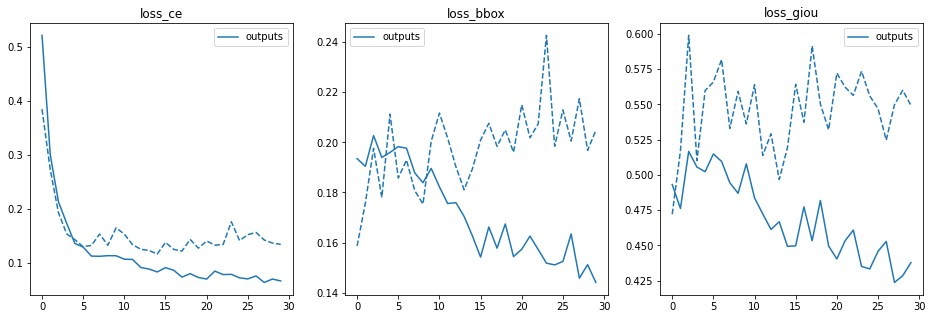

In [4]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

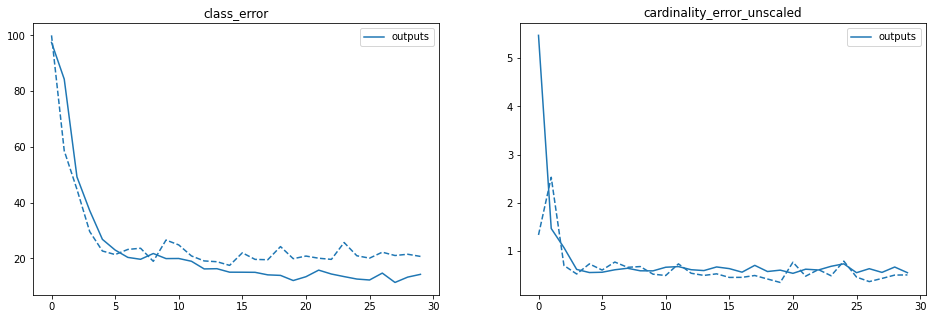

In [5]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)  

In [10]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval()

Using cache found in C:\Users\adrian/.cache\torch\hub\facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [11]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [12]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


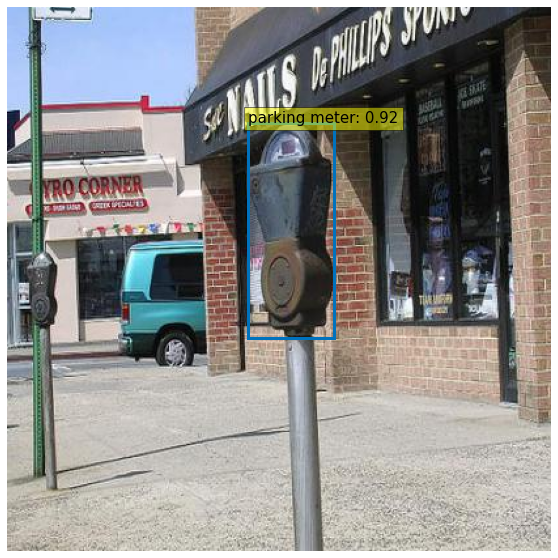

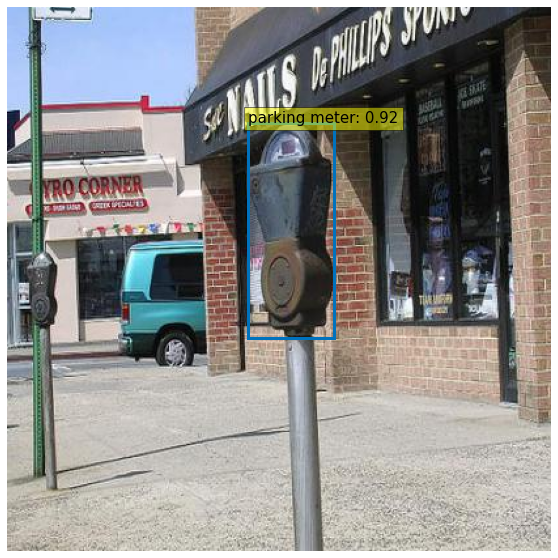

In [20]:
from PIL import Image

img_name = './train_custom_coco/train2017/000000003148_jpg.rf.07dc73a175b8da8279d5502b20335185.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

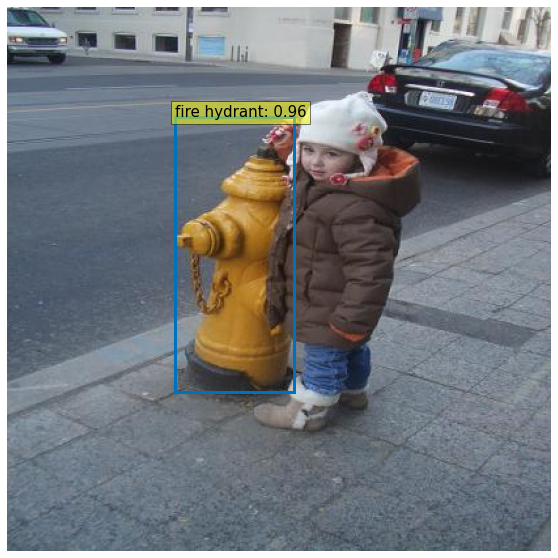

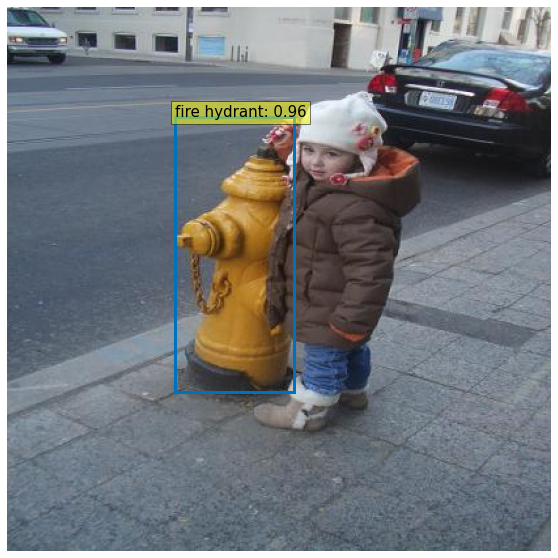

In [21]:
from PIL import Image

img_name = './train_custom_coco/val2017/000000042763_jpg.rf.c3fbbc0846f71468623b8030620f12bf.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

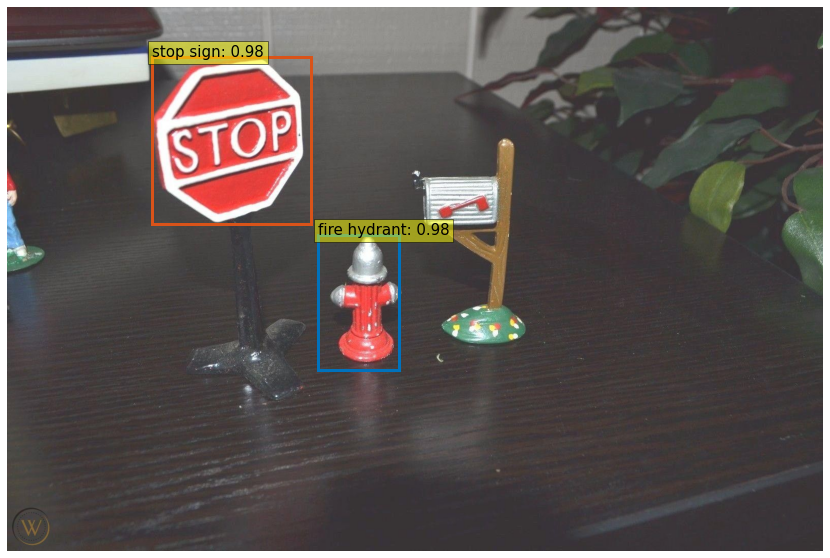

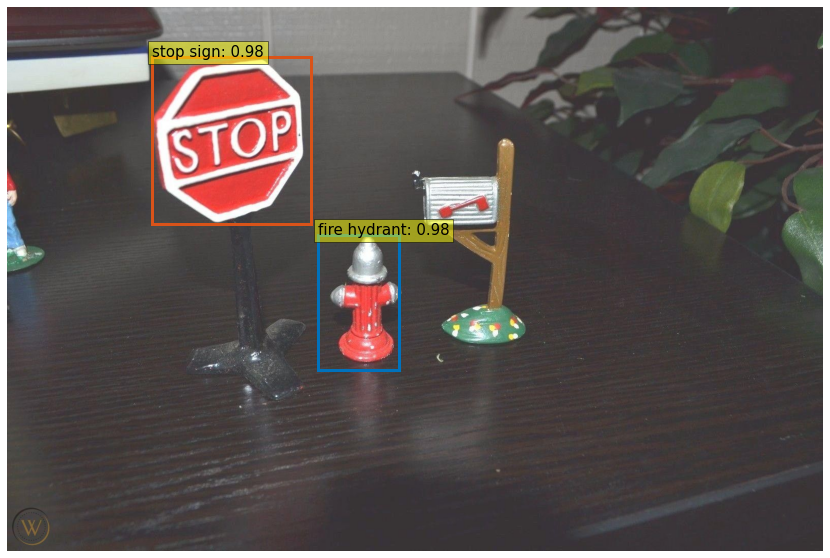

In [25]:
from PIL import Image

img_name = './train_custom_coco/image_test/prueba2.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)